In [2]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0-alpha0
        !pip install tfp-nightly==0.7.0-dev20190511
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  True


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)


TFP Version 0.7.0
TF  Version 2.0.0-alpha0


In [0]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 9s 0us/step


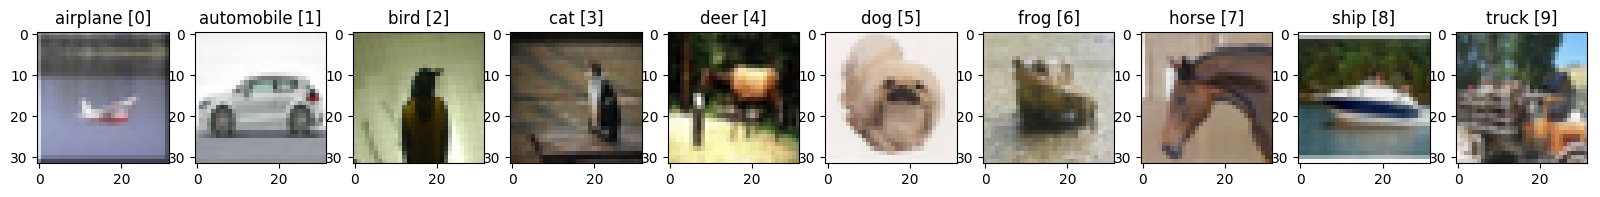

In [6]:
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
#sample image of each label
plt.figure(figsize=(20,20))
for i in range(0,len(np.unique(y_train))):
    rmd=np.random.choice(np.where(y_train==i)[0],1)
    plt.subplot(1,10,i+1)
    img=x_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(labels[i]+" "+np.str(y_train[rmd][0]))

In [0]:
#we delete all horses of the dataset
y_train_no_horse=np.delete(y_train,np.where(y_train==7)[0])
x_train_no_horse=np.delete(x_train,np.where(y_train==7)[0],axis=0)

In [8]:
print(y_train_no_horse.shape)
print(x_train_no_horse.shape)

(45000,)
(45000, 32, 32, 3)


In [0]:
y_train_no_horse=np.array(pd.get_dummies(y_train_no_horse))
labels_no_horse=np.array(["airplane","automobile","bird","cat","deer","dog","frog","ship","truck"])


In [10]:
print(y_train_no_horse.shape)

(45000, 9)


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_no_horse, y_train_no_horse, test_size=0.4, random_state=22)


In [12]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(27000, 32, 32, 3)
(27000, 9)
(18000, 32, 32, 3)
(18000, 9)
(10000, 32, 32, 3)
(10000, 1)


In [0]:
## tf norm
x_train=((x_train/255)-0.5)*2
x_val=((x_val/255)-0.5)*2
x_test=((x_test/255)-0.5)*2

## Baseline "normal" CNN

In [14]:
from tensorflow.keras.layers import Convolution2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras import Sequential

model = Sequential()
model.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu',input_shape=(32,32,3)))
model.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dropout((0.5)))
model.add(Dense(9, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [16]:
history=model.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=5,verbose=1)
#nach  30 epochs overfitting

Train on 27000 samples, validate on 18000 samples
Epoch 1/5
27000/27000 [==============================] - 3s 96us/sample - loss: 1.7596 - accuracy: 0.3360 - val_loss: 1.4530 - val_accuracy: 0.4678
Epoch 2/5
27000/27000 [==============================] - 2s 84us/sample - loss: 1.4610 - accuracy: 0.4523 - val_loss: 1.3009 - val_accuracy: 0.5241
Epoch 3/5
27000/27000 [==============================] - 2s 86us/sample - loss: 1.3469 - accuracy: 0.4987 - val_loss: 1.2015 - val_accuracy: 0.5565
Epoch 4/5
27000/27000 [==============================] - 2s 86us/sample - loss: 1.2777 - accuracy: 0.5215 - val_loss: 1.1592 - val_accuracy: 0.5699
Epoch 5/5
27000/27000 [==============================] - 2s 84us/sample - loss: 1.2346 - accuracy: 0.5430 - val_loss: 1.1343 - val_accuracy: 0.5842


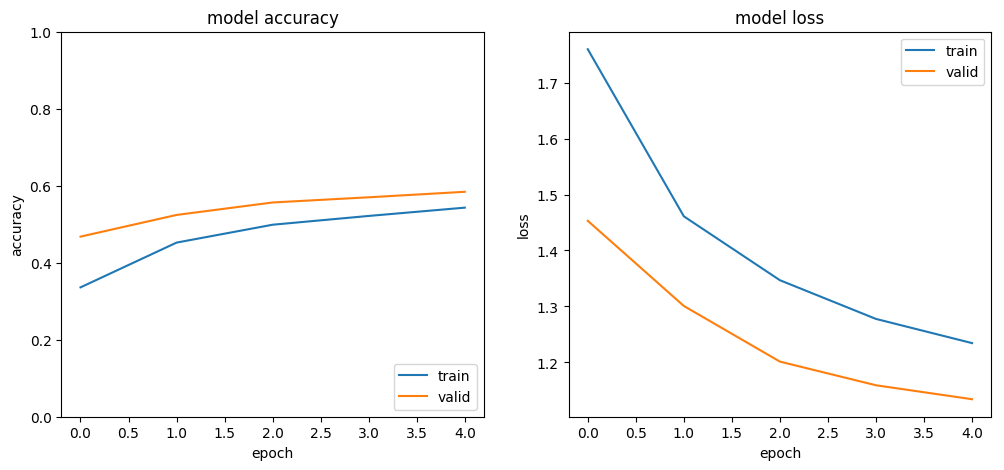

In [17]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

## Variational Inference

In [18]:


kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x_train.shape[0] * 1.0)
model_vi = Sequential()
model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn,input_shape=(32,32,3)))
model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
model_vi.add(tf.keras.layers.Flatten())
model_vi.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.DenseFlipout(9, activation = 'softmax', kernel_divergence_fn=kernel_divergence_fn))

model_vi.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model_vi.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 32, 32, 8)         440       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_flipout_2 (Conv2DFlip (None, 16, 16, 16)        2320      
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)             

In [19]:
for i in range(0,5):
  print(model_vi.predict(x_train[0:1])[0])
#we get a different pred at every run!

[0.06339498 0.09350496 0.10309189 0.1583116  0.12120808 0.12417781
 0.05472225 0.17703058 0.10455785]
[0.05010165 0.23148024 0.05207209 0.15083036 0.09228959 0.06042267
 0.05569027 0.2160703  0.09104279]
[0.04439525 0.08472203 0.05479183 0.06466223 0.15629768 0.05435025
 0.13184316 0.35190457 0.05703301]
[0.11430048 0.1225201  0.06145617 0.12256356 0.0846968  0.14795041
 0.09136701 0.17767888 0.07746662]
[0.0350646  0.08234686 0.04669208 0.10946283 0.13831426 0.11102486
 0.07222307 0.30578744 0.09908399]


In [20]:
history=model_vi.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=5,verbose=1)
# need a lot of epochs
# longer training would maybe give some improvement

Train on 27000 samples, validate on 18000 samples
Epoch 1/5
27000/27000 [==============================] - 4s 162us/sample - loss: 11.6976 - accuracy: 0.2612 - val_loss: 11.1896 - val_accuracy: 0.3517
Epoch 2/5
27000/27000 [==============================] - 3s 127us/sample - loss: 10.8474 - accuracy: 0.3747 - val_loss: 10.5019 - val_accuracy: 0.4035
Epoch 3/5
27000/27000 [==============================] - 3s 128us/sample - loss: 10.2109 - accuracy: 0.4219 - val_loss: 9.9202 - val_accuracy: 0.4338
Epoch 4/5
27000/27000 [==============================] - 3s 127us/sample - loss: 9.6497 - accuracy: 0.4514 - val_loss: 9.3881 - val_accuracy: 0.4640
Epoch 5/5
27000/27000 [==============================] - 3s 127us/sample - loss: 9.1305 - accuracy: 0.4717 - val_loss: 8.8925 - val_accuracy: 0.4808


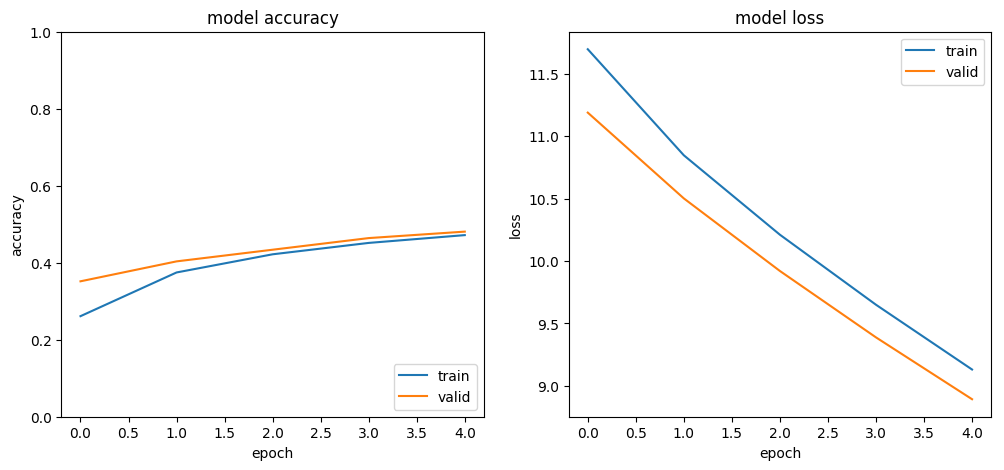

In [21]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

## MC Dropout

In [22]:
#def MCDropout(rate):
#    return tf.keras.layers.Lambda(lambda x: tf.keras.backend.dropout(x, level=rate))

model_mc = Sequential()
model_mc.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu',input_shape=(32,32,3)))
model_mc.add(Dropout((0.5)))
model_mc.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu'))
model_mc.add(Dropout((0.5)))
model_mc.add(MaxPooling2D((2,2)))
model_mc.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model_mc.add(Dropout((0.5)))
model_mc.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model_mc.add(Dropout((0.5)))
model_mc.add(MaxPooling2D((2,2)))
model_mc.add(Flatten())
model_mc.add(Dense(100, activation = 'relu'))
model_mc.add(Dropout((0.5)))
model_mc.add(Dense(9, activation = 'softmax'))

model_mc.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model_mc.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 16)       

In [23]:
for i in range(0,5):
  print(model_mc.predict(x_train[0:1])[0])
#we get a different pred at every run!

[0.12005555 0.11246056 0.10489032 0.12422423 0.10794017 0.10058745
 0.10986338 0.10956423 0.11041409]
[0.12005555 0.11246056 0.10489032 0.12422423 0.10794017 0.10058745
 0.10986338 0.10956423 0.11041409]
[0.12005555 0.11246056 0.10489032 0.12422423 0.10794017 0.10058745
 0.10986338 0.10956423 0.11041409]
[0.12005555 0.11246056 0.10489032 0.12422423 0.10794017 0.10058745
 0.10986338 0.10956423 0.11041409]
[0.12005555 0.11246056 0.10489032 0.12422423 0.10794017 0.10058745
 0.10986338 0.10956423 0.11041409]


In [0]:
import tensorflow.keras.backend as K
#f = K.function([model_mc.input], [model_mc.output])
model_mc_pred = K.function([model_mc.input, K.learning_phase()], [model_mc.output])



In [36]:
for i in range(0,5):
  print(model_mc_pred([x_train[0:1],0])[0])

[[0.31024387 0.01560806 0.1604408  0.05813866 0.09869403 0.05033825
  0.0181169  0.2626259  0.02579344]]
[[0.31024387 0.01560806 0.1604408  0.05813866 0.09869403 0.05033825
  0.0181169  0.2626259  0.02579344]]
[[0.31024387 0.01560806 0.1604408  0.05813866 0.09869403 0.05033825
  0.0181169  0.2626259  0.02579344]]
[[0.31024387 0.01560806 0.1604408  0.05813866 0.09869403 0.05033825
  0.0181169  0.2626259  0.02579344]]
[[0.31024387 0.01560806 0.1604408  0.05813866 0.09869403 0.05033825
  0.0181169  0.2626259  0.02579344]]


In [33]:
history=model_mc.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=5,verbose=1)

Train on 27000 samples, validate on 18000 samples
Epoch 1/5
27000/27000 [==============================] - 3s 116us/sample - loss: 2.0098 - accuracy: 0.2351 - val_loss: 2.0035 - val_accuracy: 0.3047
Epoch 2/5
27000/27000 [==============================] - 3s 95us/sample - loss: 1.7566 - accuracy: 0.3290 - val_loss: 1.8850 - val_accuracy: 0.3347
Epoch 3/5
27000/27000 [==============================] - 2s 92us/sample - loss: 1.6273 - accuracy: 0.3784 - val_loss: 1.8148 - val_accuracy: 0.3067
Epoch 4/5
27000/27000 [==============================] - 3s 94us/sample - loss: 1.5529 - accuracy: 0.4096 - val_loss: 1.7464 - val_accuracy: 0.3139
Epoch 5/5
27000/27000 [==============================] - 3s 93us/sample - loss: 1.5011 - accuracy: 0.4284 - val_loss: 1.7274 - val_accuracy: 0.3384


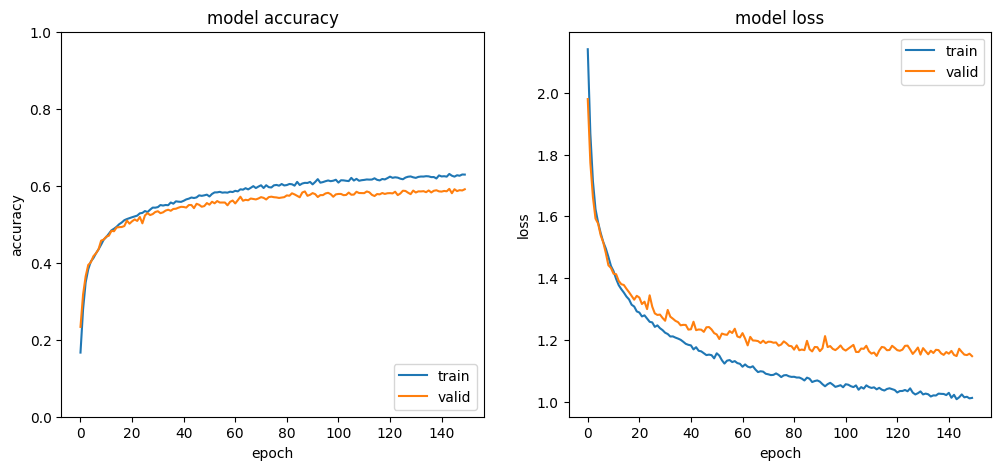

In [0]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### Acc on the lables in the train set for all three models
VI and MC 50 preds und then argmax of mean

In [0]:
known_idx=np.where(y_test!=7)[0]
print(len(known_idx))
x_test_known = x_test[known_idx]
y_test_known = y_test[known_idx]

unknown_idx=np.where(y_test==7)[0]
print(len(unknown_idx))
x_test_unknown = x_test[unknown_idx]
y_test_unknown = y_test[unknown_idx]

9000
1000


In [0]:
pred=np.argmax(model.predict(x_test_known),axis=1)
pred_label=np.array([labels_no_horse[np.int(pred[i])] for i in range(0,len(pred))])
true_label=np.array([labels[np.int(y_test_known[i])] for i in range(0,len(y_test_known))])
print("test_acc_on_known_lables =",np.sum(pred_label==true_label)/len(true_label) )
test_acc_known = np.sum(pred_label==true_label)/len(true_label)


test_acc_on_known_lables = 0.6591111111111111


In [0]:
from tqdm import tqdm_notebook as tqdm

In [0]:
# 50 pred and then mean and argmax for the val set
SET=x_test_known
pred=np.zeros((len(SET),1))
for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred[i]=np.argmax(np.mean(preds,axis=0))#mean over n runs of every proba class

In [0]:
pred_label=np.array([labels_no_horse[np.int(pred[i])] for i in range(0,len(pred))])
true_label=np.array([labels[np.int(y_test_known[i])] for i in range(0,len(y_test_known))])
print("test_acc_on_known_lables =",np.sum(pred_label==true_label)/len(true_label) )
test_acc_known_vi = np.sum(pred_label==true_label)/len(true_label)


test_acc_on_known_lables = 0.6852222222222222


In [0]:
# 50 pred and then mean and argmax for the val set
SET=x_test_known
pred=np.zeros((len(SET),1))
for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_mc.predict(multi_img)
  pred[i]=np.argmax(np.mean(preds,axis=0))#mean over n runs of every proba class

In [0]:
pred_label=np.array([labels_no_horse[np.int(pred[i])] for i in range(0,len(pred))])
true_label=np.array([labels[np.int(y_test_known[i])] for i in range(0,len(y_test_known))])
print("test_acc_on_known_lables =",np.sum(pred_label==true_label)/len(true_label) )
test_acc_known_mc = np.sum(pred_label==true_label)/len(true_label)


test_acc_on_known_lables = 0.676


In [0]:
import pandas as pd
pd.DataFrame(np.column_stack([test_acc_known,test_acc_known_vi,test_acc_known_mc]), index=['test acc on known labels'],columns=['baseline','VI','MC'])

,baseline,VI,MC
test acc on known labels,0.659111,0.685222,0.676


In [0]:
print("test_acc =" ,np.sum(pred_mean_label==true_label)/len(true_label))
#test acc 

test_acc = 0.6215


In [0]:
pred=np.argmax(model.predict(x_test_unknown),axis=1)
pred_label=np.array([labels_no_horse[np.int(pred[i])] for i in range(0,len(pred))])

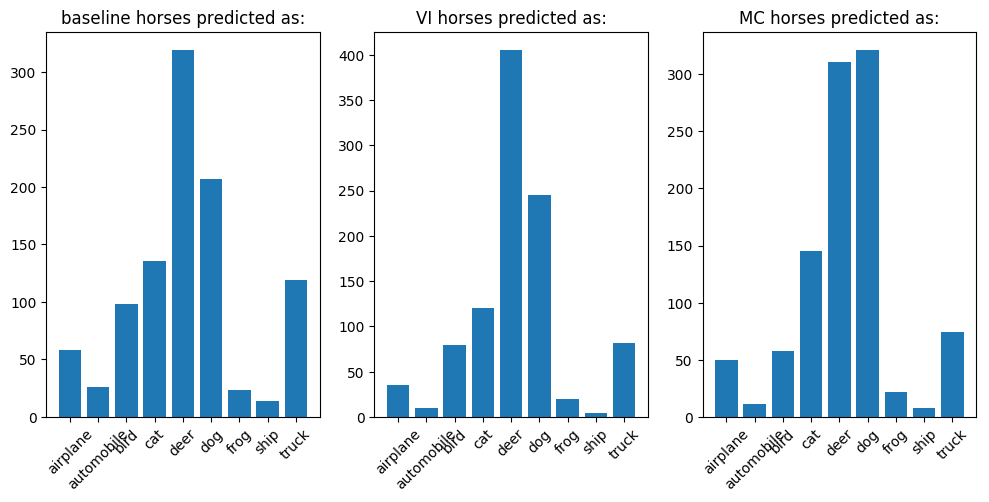

In [0]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
pred=np.argmax(model.predict(x_test_unknown),axis=1)
pred_label=np.array([labels_no_horse[np.int(pred[i])] for i in range(0,len(pred))])
plt.bar(np.unique(pred_label,return_counts=True)[0],np.unique(pred_label,return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("baseline horses predicted as:")
plt.subplot(1,3,2)
SET=x_test_unknown
pred=np.zeros((len(SET),1))
for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred[i]=np.argmax(np.mean(preds,axis=0))#mean over n runs of every proba class
pred_label=np.array([labels_no_horse[np.int(pred[i])] for i in range(0,len(pred))])
plt.bar(np.unique(pred_label,return_counts=True)[0],np.unique(pred_label,return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("VI horses predicted as:")
plt.subplot(1,3,3)
SET=x_test_unknown
pred=np.zeros((len(SET),1))
for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_mc.predict(multi_img)
  pred[i]=np.argmax(np.mean(preds,axis=0))#mean over n runs of every proba class
pred_label=np.array([labels_no_horse[np.int(pred[i])] for i in range(0,len(pred))])
plt.bar(np.unique(pred_label,return_counts=True)[0],np.unique(pred_label,return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("MC horses predicted as:")
plt.show()

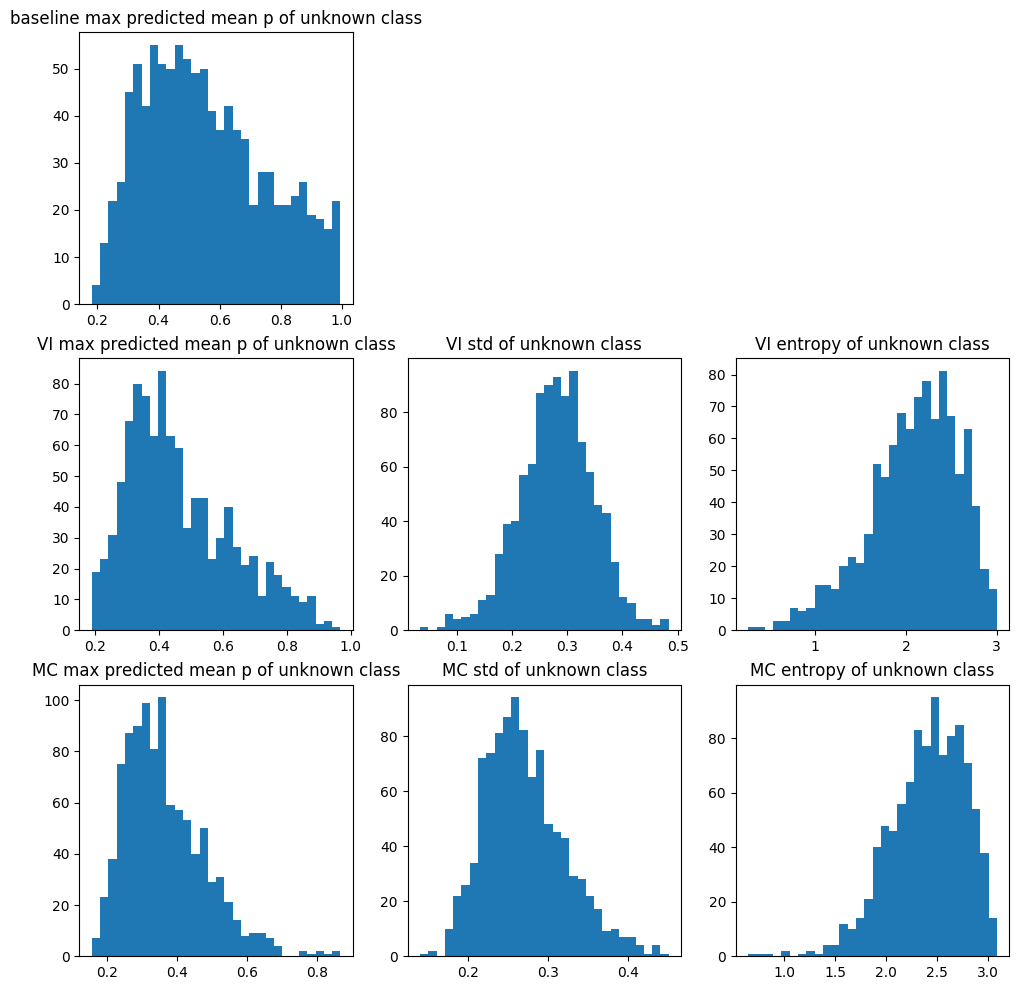

In [0]:

## look at the means sd and entropy of the true horses of the testset,
## here we want to see a hight uncertainty

pred=model.predict(x_test_unknown)
pred_uk=np.max(pred,axis=1)

plt.figure(figsize=(12,12))
plt.subplot(3,3,1)
plt.hist(pred_uk,bins=30)
plt.title("baseline max predicted mean p of unknown class")
plt.subplot(3,3,2)
plt.axis("off")
plt.subplot(3,3,3)
plt.axis("off")

SET=x_test_unknown
pred=np.zeros((len(SET),1))
pred_std_uk=np.zeros((len(SET),1))
pred_means_uk=np.zeros((len(SET),9))
entropy_uk = np.zeros((len(SET),1))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_means_uk[i]= np.mean(preds,axis=0)
  pred[i]=np.argmax(np.mean(preds,axis=0))
  pred_std_uk[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy_uk[i] = -np.sum( pred_means_uk[i] * np.log2(pred_means_uk[i] + 1E-14)) #Numerical Stability

plt.subplot(3,3,4)
plt.hist(np.max(pred_means_uk,axis=1),bins=30)
plt.title("VI max predicted mean p of unknown class")
plt.subplot(3,3,5)
plt.hist(pred_std_uk,bins=30)
plt.title("VI std of unknown class")
plt.subplot(3,3,6)
plt.hist(entropy_uk,bins=30)
plt.title("VI entropy of unknown class")



SET=x_test_unknown
pred=np.zeros((len(SET),1))
pred_std_uk=np.zeros((len(SET),1))
pred_means_uk=np.zeros((len(SET),9))
entropy_uk = np.zeros((len(SET),1))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_mc.predict(multi_img)
  pred_means_uk[i]= np.mean(preds,axis=0)
  pred[i]=np.argmax(np.mean(preds,axis=0))
  pred_std_uk[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy_uk[i] = -np.sum( pred_means_uk[i] * np.log2(pred_means_uk[i] + 1E-14)) #Numerical Stability

plt.subplot(3,3,7)
plt.hist(np.max(pred_means_uk,axis=1),bins=30)
plt.title("MC max predicted mean p of unknown class")
plt.subplot(3,3,8)
plt.hist(pred_std_uk,bins=30)
plt.title("MC std of unknown class")
plt.subplot(3,3,9)
plt.hist(entropy_uk,bins=30)
plt.title("MC entropy of unknown class")
plt.show()


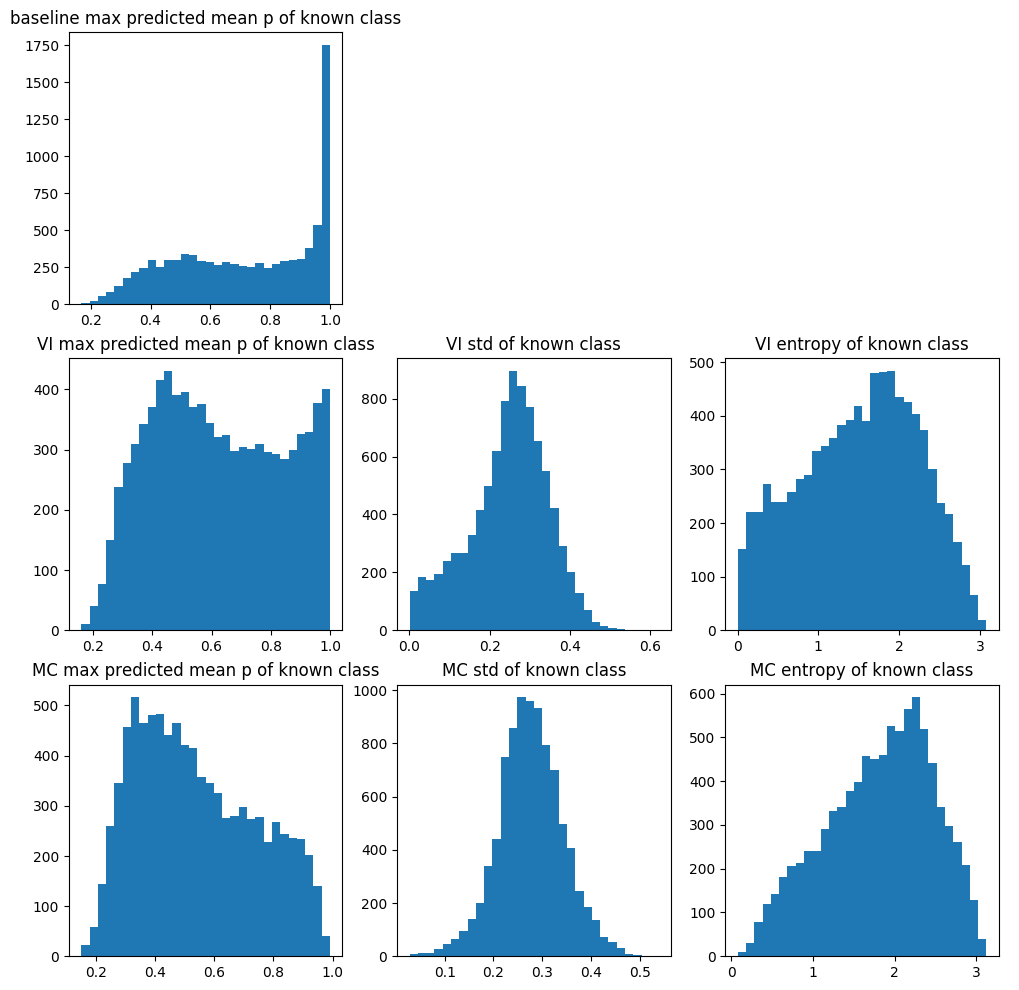

In [0]:
## look at the means sd and entropy of the known classes of the testset,
## here we want to see a low uncertainty

pred=model.predict(x_test_known)
pred_uk=np.max(pred,axis=1)

plt.figure(figsize=(12,12))
plt.subplot(3,3,1)
plt.hist(pred_uk,bins=30)
plt.title("baseline max predicted mean p of known class")
plt.subplot(3,3,2)
plt.axis("off")
plt.subplot(3,3,3)
plt.axis("off")

SET=x_test_known
pred=np.zeros((len(SET),1))
pred_std_uk=np.zeros((len(SET),1))
pred_means_uk=np.zeros((len(SET),9))
entropy_uk = np.zeros((len(SET),1))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_means_uk[i]= np.mean(preds,axis=0)
  pred[i]=np.argmax(np.mean(preds,axis=0))
  pred_std_uk[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy_uk[i] = -np.sum( pred_means_uk[i] * np.log2(pred_means_uk[i] + 1E-14)) #Numerical Stability

plt.subplot(3,3,4)
plt.hist(np.max(pred_means_uk,axis=1),bins=30)
plt.title("VI max predicted mean p of known class")
plt.subplot(3,3,5)
plt.hist(pred_std_uk,bins=30)
plt.title("VI std of known class")
plt.subplot(3,3,6)
plt.hist(entropy_uk,bins=30)
plt.title("VI entropy of known class")



SET=x_test_known
pred=np.zeros((len(SET),1))
pred_std_uk=np.zeros((len(SET),1))
pred_means_uk=np.zeros((len(SET),9))
entropy_uk = np.zeros((len(SET),1))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_mc.predict(multi_img)
  pred_means_uk[i]= np.mean(preds,axis=0)
  pred[i]=np.argmax(np.mean(preds,axis=0))
  pred_std_uk[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy_uk[i] = -np.sum( pred_means_uk[i] * np.log2(pred_means_uk[i] + 1E-14)) #Numerical Stability

plt.subplot(3,3,7)
plt.hist(np.max(pred_means_uk,axis=1),bins=30)
plt.title("MC max predicted mean p of known class")
plt.subplot(3,3,8)
plt.hist(pred_std_uk,bins=30)
plt.title("MC std of known class")
plt.subplot(3,3,9)
plt.hist(entropy_uk,bins=30)
plt.title("MC entropy of known class")
plt.show()


## Filter our preds with pmax and p_mean

In [0]:
pred=model.predict(x_test)
pred=np.max(pred,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))
certainty_idx = certainty_idx[::-1]#reverse
print(certainty_idx[0:10])
print(pred[certainty_idx[0:10]])

[1833 5526 9619 5989 2156 5720 8195 9814 8931 5124]
[1.         1.         0.9999999  0.9999999  0.99999976 0.9999995
 0.9999995  0.9999994  0.9999987  0.9999987 ]


In [0]:
acc_nbest

array([1., 1., 1., ..., 1., 1., 1.])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


[3982 6104 7715 8150 3691 6672  252 2445 1915 5720]
[0.99976754 0.9997043  0.99966997 0.99965966 0.99963117 0.99957705
 0.9992975  0.99921179 0.99910378 0.99903291]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars


[9814 5935  235 9138 9614 9565 9531 2052 8150 4671]
[0.98692924 0.98664939 0.98645109 0.98534089 0.9852531  0.98094934
 0.98066038 0.97959548 0.97898889 0.97877854]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in long_scalars


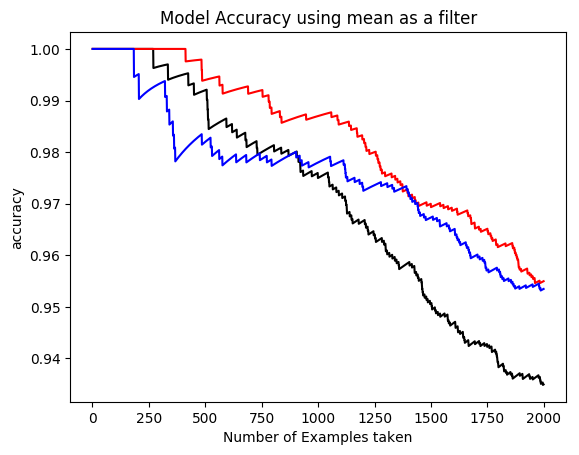

In [0]:
pred=model.predict(x_test)
pred=np.max(pred,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))
certainty_idx = certainty_idx[::-1]#reverse


pred=model.predict(x_test)
acc_nbest = np.zeros((2000))
for j in tqdm(range(0,2000)):
  pred_am=np.argmax(pred[certainty_idx[0:j]],axis=1)
  pred_label=np.array([labels_no_horse[np.int(pred_am[i])] for i in range(0,len(pred_am))])
  tmp=y_test[certainty_idx[0:j]]
  true_label=np.array([labels[np.int(tmp[i])] for i in range(0,len(tmp))])
  acc_nbest[j]=(np.sum(pred_label==true_label)/len(pred_label))

plt.plot(acc_nbest,c="black")
plt.title('Model Accuracy using mean as a filter')
plt.ylabel('accuracy')
plt.xlabel('Number of Examples taken')


SET=x_test
pred=np.zeros((len(SET),1))
pred_means_uk=np.zeros((len(SET),9))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_means_uk[i]= np.mean(preds,axis=0)

pred=np.max(pred_means_uk,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))
certainty_idx = certainty_idx[::-1]#reverse
print(certainty_idx[0:10])
print(pred[certainty_idx[0:10]])

acc_nbest = np.zeros((2000))
for j in tqdm(range(0,2000)):
  pred_am=np.argmax(pred_means_uk[certainty_idx[0:j]],axis=1)
  pred_label=np.array([labels_no_horse[np.int(pred_am[i])] for i in range(0,len(pred_am))])
  tmp=y_test[certainty_idx[0:j]]
  true_label=np.array([labels[np.int(tmp[i])] for i in range(0,len(tmp))])
  acc_nbest[j]=(np.sum(pred_label==true_label)/len(pred_label))
  
plt.plot(acc_nbest,c="red")



SET=x_test
pred=np.zeros((len(SET),1))
pred_means_uk=np.zeros((len(SET),9))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_mc.predict(multi_img)
  pred_means_uk[i]= np.mean(preds,axis=0)

pred=np.max(pred_means_uk,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))
certainty_idx = certainty_idx[::-1]#reverse
print(certainty_idx[0:10])
print(pred[certainty_idx[0:10]])

acc_nbest = np.zeros((2000))
for j in tqdm(range(0,2000)):
  pred_am=np.argmax(pred_means_uk[certainty_idx[0:j]],axis=1)
  pred_label=np.array([labels_no_horse[np.int(pred_am[i])] for i in range(0,len(pred_am))])
  tmp=y_test[certainty_idx[0:j]]
  true_label=np.array([labels[np.int(tmp[i])] for i in range(0,len(tmp))])
  acc_nbest[j]=(np.sum(pred_label==true_label)/len(pred_label))
  
plt.plot(acc_nbest,c="blue")
